/var/folders/s8/386m99xn5q5c23fb_xkzv20w0000gn/T/ipykernel_3610/4097929119.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_max{wmax}"] = roll_max(s, wmax)
/var/folders/s8/386m99xn5q5c23fb_xkzv20w0000gn/T/ipykernel_3610/4097929119.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_ewm_hl{hl}"] = ewm_mean(s, hl)
/var/folders/s8/386m99xn5q5c23fb_xkzv20w0000gn/T/ipykernel_3610/4097929119.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,


[회귀] (AR 포함, Lasso) 성능
- Split=A | log_R2=0.987 | real_MAE=134.92 | n_features=130 | win=(160,170), hl=30
[진단] y_train std (log): 0.284874
[진단] 저분산 제거 후 피처 수: 122 / 128


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019007553664724952, tolerance: 0.011253454180046897
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02224222799082831, tolerance: 0.011253454180046897
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06658543279607443, tolerance: 0.011253454180046897
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinat

[회귀-해석] ElasticNet 선택 α: 7.61e-02, l1_ratio: 0.8 | 비영(非0) 계수 수: 6

[회귀-해석] ElasticNet(날씨-only) 계수 절댓값 Top 15
WS_AVG_max170      0.0699935
EV_L_min170        0.0291116
HM_AVG_std170       0.025712
TA_MIN_min170      0.0122222
WS_AVG_min170     0.00336608
TA_MAX_min170     0.00016428
SI_DAY_std170              0
SI_DAY_min170              0
SI_DAY_max170              0
SI_DAY_ewm_hl30            0
TA_AVG_sum170              0
RN_DAY_sum170              0
SI_DAY_sum170              0
RN_DAY_sum160              0
RN_DAY_std170              0
dtype: float64

[회귀-해석] 트리 기반 퍼뮤테이션 중요도 Top 15
TS_AVG_max170      0.0605013
SI_DAY_min170      0.0220556
HM_AVG_std170      0.0118487
RN_DUR_sum170      0.0116399
TS_AVG_sum160       0.009743
TS_AVG_std170      0.0094162
WS_AVG_max170     0.00803699
TS_AVG_min170      0.0078316
TA_MAX_sum160     0.00653977
TG_MIN_ewm_hl30   0.00640315
RN_DUR_sum160     0.00608722
SI_DAY_sum160     0.00571334
PV_AVG_std170     0.00566855
HM_AVG_ewm_hl30   0.00462527
SS_

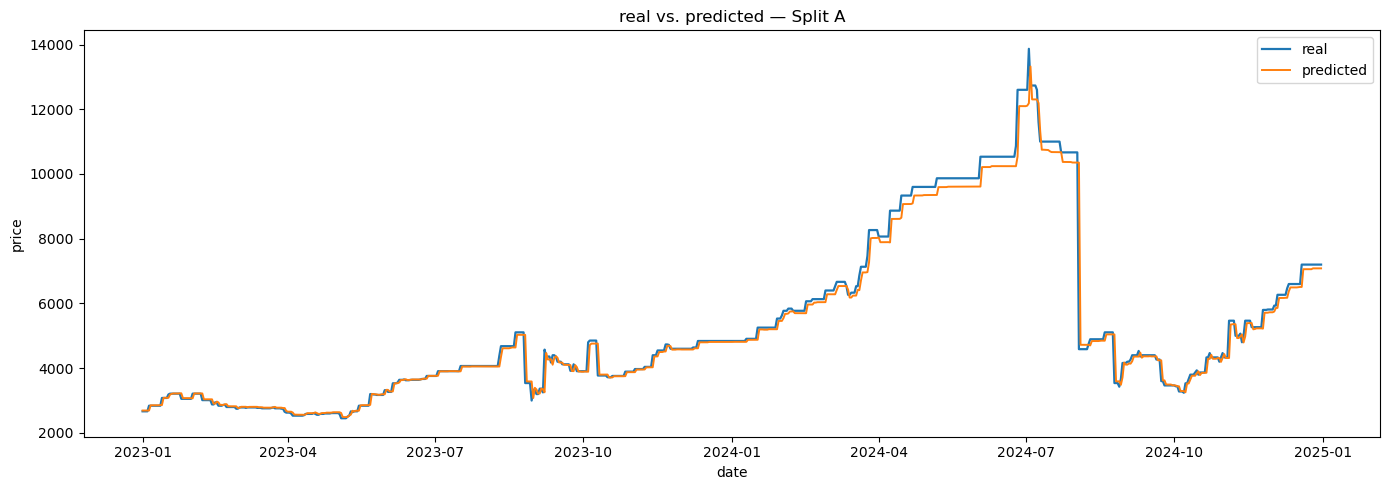


[분류] (AR 포함, Logistic) 성능
- Split=A | ROC-AUC=0.672 | F1=0.507 | pctl=0.7

[분류] 중요도 Top 15
ARlog_lag1         0.168536
RN_DUR_std170      0.163475
SS_DUR_max170     0.0478796
TG_MIN_min170     0.0369357
TG_MIN_ewm_hl30   0.0326949
TG_MIN_sum170     0.0268126
SS_DAY_max170     0.0248974
PV_AVG_min170     0.0240766
TG_MIN_sum160     0.0218878
RN_DUR_ewm_hl30   0.0214774
TS_AVG_ewm_hl30   0.0212038
WS_AVG_ewm_hl30   0.0155951
SD_NEW_sum160     0.0129959
TA_MIN_ewm_hl30   0.0123119
SD_MAX_sum160     0.0117647
dtype: float64


In [1]:
# Regression
# Classification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, r2_score, roc_auc_score, f1_score, silhouette_score
)
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

# =========================
# 0) 사용자 입력
# =========================
CSV = "배_preprocessed.csv"           # ← 분석할 파일명
WIN_MIN, WIN_MAX = 160, 170          # ← 생산기간 누적창(예: 배 160~170일)
EWM_HALFLIFE = 30                    # 지수가중 반감기
SPLIT_STRATEGY = "A"                 # "A" 또는 "B"
CLASS_PCTL = 0.70                    # 분류: 고가일 정의(연도별 확장 70백분위)
TOP_N = 15                           # 랭킹 출력 개수
K_RANGE = range(3, 7)                # KMeans 후보 k
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# =========================
# 1) 데이터 로드
# =========================
df = pd.read_csv(CSV, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
date_col, year_col = "date", "year"
price_col = df.columns[-1]
df.loc[df[price_col] <= 0, price_col] = np.nan
climate_cols = [c for c in df.columns if c not in [date_col, year_col, price_col]]

# =========================
# 2) 피처 생성 (미래누수 방지: shift(1))
# =========================
def roll_sum(s, w): return s.rolling(w, min_periods=w).sum().shift(1)
def roll_std(s, w): return s.rolling(w, min_periods=w).std(ddof=0).shift(1)
def roll_min(s, w): return s.rolling(w, min_periods=w).min().shift(1)
def roll_max(s, w): return s.rolling(w, min_periods=w).max().shift(1)
def ewm_mean(s, hl): return s.shift(1).ewm(halflife=hl, adjust=False).mean()

def build_features(df, wmin, wmax, hl):
    X = pd.DataFrame(index=df.index)
    for c in climate_cols:
        s = df[c].astype(float)
        X[f"{c}_sum{wmax}"] = roll_sum(s, wmax)
        X[f"{c}_sum{wmin}"] = roll_sum(s, wmin)
        X[f"{c}_std{wmax}"] = roll_std(s, wmax)
        X[f"{c}_min{wmax}"] = roll_min(s, wmax)
        X[f"{c}_max{wmax}"] = roll_max(s, wmax)
        X[f"{c}_ewm_hl{hl}"] = ewm_mean(s, hl)

    # 캘린더(보조)
    doy = df[date_col].dt.dayofyear
    X["sin_doy"] = np.sin(2*np.pi*doy/365.25)
    X["cos_doy"] = np.cos(2*np.pi*doy/365.25)

    # 타깃(로그)
    y_real = df[price_col].astype(float)
    y_log  = np.log1p(y_real)

    # AR(log) 랙 — 회귀/분류에서 사용
    X["ARlog_lag1"] = y_log.shift(1)
    X["ARlog_lag7"] = y_log.shift(7)

    valid = X.notna().all(axis=1) & y_log.notna()
    return X.loc[valid], y_log.loc[valid], y_real.loc[valid], df.loc[valid, [date_col, year_col]]

X_all, y_log, y_real, meta = build_features(df, WIN_MIN, WIN_MAX, EWM_HALFLIFE)

# =========================
# 3) 분할전략 A/B
# =========================
if SPLIT_STRATEGY == "A":
    train_mask = meta[year_col].between(2018, 2022)
    test_mask  = meta[year_col].between(2023, 2024)
elif SPLIT_STRATEGY == "B":
    d = meta[date_col]
    train_mask = (meta[year_col].isin([2018, 2019])) | ((d >= "2023-01-01") & (d <= "2023-06-30"))
    test_mask  = ((d >= "2023-07-01") & (d <= "2024-12-31"))
else:
    raise ValueError("SPLIT_STRATEGY는 'A' 또는 'B'만 허용됩니다.")

# =========================
# 4) 회귀 — AR 포함 Lasso
# =========================
X_train, y_train = X_all[train_mask], y_log[train_mask]
X_test,  y_test  = X_all[test_mask],  y_log[test_mask]
y_real_test = y_real[test_mask]; meta_test = meta[test_mask]

reg = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LassoCV(cv=5, random_state=RANDOM_STATE, n_alphas=100, max_iter=20000))
])
reg.fit(X_train, y_train)

pred_log  = pd.Series(reg.predict(X_test), index=X_test.index)
pred_real = np.expm1(pred_log)

print("\n[회귀] (AR 포함, Lasso) 성능")
print(f"- Split={SPLIT_STRATEGY} | log_R2={r2_score(y_test, pred_log):.3f} | "
      f"real_MAE={mean_absolute_error(y_real_test, pred_real):.2f} | "
      f"n_features={X_train.shape[1]} | win=({WIN_MIN},{WIN_MAX}), hl={EWM_HALFLIFE}")

# ---- (A) 진단: y(로그가격) 변동성 확인
print(f"[진단] y_train std (log): {y_train.std():.6f}")

# ---- (B) 날씨-only 행렬 만들기 + 저분산 제거
weather_cols_only = [c for c in X_all.columns if not c.startswith("ARlog_")]
Xw_tr_full = X_train[weather_cols_only].copy()
Xw_te_full = X_test[weather_cols_only].copy()

vt = VarianceThreshold(threshold=1e-8)  # 거의 상수인 컬럼 제거
Xw_tr = vt.fit_transform(Xw_tr_full)
Xw_te = vt.transform(Xw_te_full)
kept_cols = Xw_tr_full.columns[vt.get_support()]
print(f"[진단] 저분산 제거 후 피처 수: {len(kept_cols)} / {len(weather_cols_only)}")

# ---- (C) ElasticNetCV로 계수 랭킹
enet = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.8],             # 라쏘(=1)보다 완화
        alphas=np.logspace(-6, 0, 60),             # 규제 강도 낮은 쪽도 탐색
        cv=5, random_state=RANDOM_STATE, max_iter=100000
    ))
])
enet.fit(Xw_tr, y_train)

enet_coef = pd.Series(enet.named_steps["model"].coef_, index=kept_cols)
nz = (enet_coef.abs() > 0).sum()
print(f"[회귀-해석] ElasticNet 선택 α: {enet.named_steps['model'].alpha_:.2e}, "
      f"l1_ratio: {enet.named_steps['model'].l1_ratio_} | 비영(非0) 계수 수: {nz}")

if nz == 0:
    # ---- (D) Fallback: RidgeCV
    ridge = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", RidgeCV(alphas=np.logspace(-6, 3, 40), cv=5))
    ])
    ridge.fit(Xw_tr, y_train)
    rcoef = pd.Series(ridge.named_steps["model"].coef_, index=kept_cols)
    top_linear = rcoef.abs().sort_values(ascending=False).head(TOP_N)
    print("\n[회귀-해석] RidgeCV(계수 절댓값 Top, 라쏘/EN이 전부 0일 때 대안)")
    print(top_linear)
else:
    top_enet = enet_coef.abs().sort_values(ascending=False).head(TOP_N)
    print("\n[회귀-해석] ElasticNet(날씨-only) 계수 절댓값 Top", TOP_N)
    # 작은 수가 0.0으로 보이는 문제를 피하려면 표시 형식 늘리기
    pd.set_option('display.float_format', lambda v: f"{v:.6g}")
    print(top_enet)

# ---- (E) 비선형 신호 확인: 트리 + 퍼뮤테이션 중요도
tree = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
tree.fit(Xw_tr, y_train)
pi = permutation_importance(tree, Xw_te, y_test, n_repeats=10, random_state=RANDOM_STATE)
imp_tree = pd.Series(pi.importances_mean, index=kept_cols).sort_values(ascending=False).head(TOP_N)
print("\n[회귀-해석] 트리 기반 퍼뮤테이션 중요도 Top", TOP_N)
print(imp_tree)

# ---- (F) 예측 플롯 생성 (변수 정의 누락 수정 필요)
pred_df = pd.DataFrame({
    "date": meta_test[date_col],
    "real_price": y_real_test,
    "predicted_price": pred_real
}).reset_index(drop=True)

plt.figure(figsize=(14,5))
d = pd.to_datetime(pred_df["date"])
plt.plot(d, pred_df["real_price"],      label="real", linewidth=1.6)
plt.plot(d, pred_df["predicted_price"], label="predicted", linewidth=1.4)
plt.title(f"real vs. predicted — Split {SPLIT_STRATEGY}")
plt.xlabel("date"); plt.ylabel("price"); plt.legend(loc="best")
plt.tight_layout(); plt.show()

# =========================
# 5) 분류 — AR 포함 (고가일: 연도별 확장 70백분위)
# =========================
label = pd.Series(index=y_real.index, dtype=float)
for yr in sorted(meta[year_col].unique()):
    ix = (meta[year_col]==yr)
    s  = y_real[ix]
    def _exp_pctl(a):
        if len(a) <= 1: return np.nan
        return np.nanpercentile(a[:-1], CLASS_PCTL*100)
    thr = s.expanding(min_periods=30).apply(_exp_pctl, raw=False)
    label.loc[ix] = (s > thr).astype(float)

valid = label.notna()
Xc, yc, metac = X_all[valid], label[valid].astype(int), meta[valid]
trc, tec = train_mask[valid], test_mask[valid]

clf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])
clf.fit(Xc[trc], yc[trc])

proba = clf.predict_proba(Xc[tec])[:,1]
predc = (proba >= 0.5).astype(int)
auc = roc_auc_score(yc[tec], proba)
f1  = f1_score(yc[tec], predc)
print("\n[분류] (AR 포함, Logistic) 성능")
print(f"- Split={SPLIT_STRATEGY} | ROC-AUC={auc:.3f} | F1={f1:.3f} | pctl={CLASS_PCTL}")

pi = permutation_importance(clf, Xc[tec], yc[tec], n_repeats=10, random_state=RANDOM_STATE)
imp_cls = pd.Series(pi.importances_mean, index=Xc.columns).sort_values(ascending=False).head(TOP_N)
print("\n[분류] 중요도 Top", TOP_N)
print(imp_cls)

[INFO] 고구마: win=(120,180), ewm_halflife=54, vector_dim=17
[INFO] 깻잎: win=(60,90), ewm_halflife=27, vector_dim=17
[INFO] 배: win=(160,170), ewm_halflife=50, vector_dim=23
[INFO] 사과: win=(150,200), ewm_halflife=60, vector_dim=20
[INFO] 시금치: win=(30,60), ewm_halflife=18, vector_dim=23
[INFO] 쌀: win=(120,150), ewm_halflife=45, vector_dim=18
[INFO] 애호박: win=(30,60), ewm_halflife=18, vector_dim=20
[INFO] 양배추: win=(60,90), ewm_halflife=27, vector_dim=20
[INFO] 오이: win=(30,60), ewm_halflife=18, vector_dim=17

[품목별 기후 민감도 행렬] (접두 평균 |rho|)
      EV_L   EV_S  HM_AVG  HM_MIN  PV_AVG  RN_60M  RN_DAY  RN_DUR  SD_MAX  \
고구마      0      0  0.2329  0.1722  0.3091  0.1953  0.1415       0       0   
깻잎       0      0  0.4823  0.5193  0.2753  0.2505  0.2708       0       0   
배   0.1156 0.1032  0.1175  0.1547  0.0468  0.0357  0.0854  0.3255  0.0363   
사과   0.108 0.0925  0.1221  0.2179  0.1109  0.0423  0.0322       0       0   
시금치  0.372 0.3761  0.4854  0.4747   0.524  0.5465  0.4148  0.3614  0.0799   
쌀 

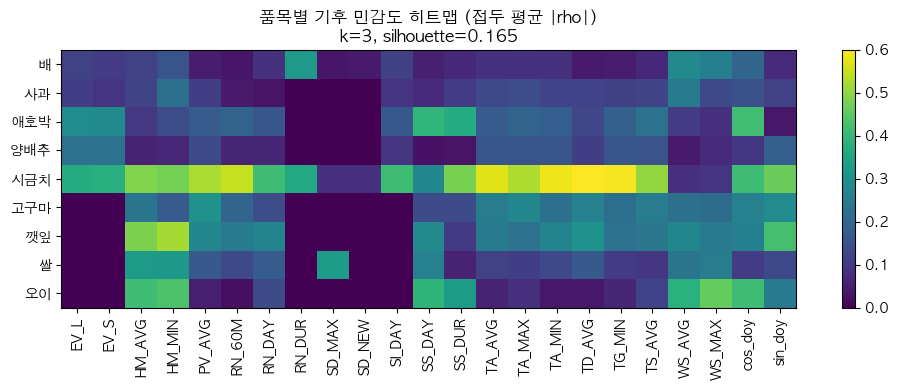

In [75]:
# Clustering

import os
import re
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold

import platform, matplotlib as mpl
mpl.rcParams["font.family"] = {"Darwin":"AppleGothic","Windows":"Malgun Gothic"}.get(platform.system(), "NanumGothic")
mpl.rcParams["axes.unicode_minus"] = False

# ----------------------------------------------------
# 공통 기본값 (해당 품목 설정이 없을 때만 사용)
# ----------------------------------------------------
DEFAULT_WIN_MIN = 150
DEFAULT_WIN_MAX = 170
DEFAULT_EWM_HALFLIFE = 30
K_CANDIDATES = [3, 4, 5, 6]
MIN_VALID_ROWS = 50
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ----------------------------------------------------
# (옵션 A) 코드 내 품목별 생산기간 매핑 (파일명에서 '배','사과' 등 추출)
# ----------------------------------------------------
PER_CROP_WINDOW = {
    "배":     dict(win_min=160, win_max=170, ewm_halflife=50),
    "사과":   dict(win_min=150, win_max=200, ewm_halflife=60),
    "고구마": dict(win_min=120, win_max=180, ewm_halflife=54),
    "깻잎":   dict(win_min=60,  win_max=90,  ewm_halflife=27),
    "시금치": dict(win_min=30,  win_max=60,  ewm_halflife=18),
    "쌀":     dict(win_min=120, win_max=150, ewm_halflife=45),
    "애호박": dict(win_min=30,  win_max=60,  ewm_halflife=18),
    "양배추": dict(win_min=60,  win_max=90,  ewm_halflife=27),
    "오이":   dict(win_min=30,  win_max=60,  ewm_halflife=18),
}

# -----------------------------
# 유틸 (누수방지 파생)
# -----------------------------
def roll_sum(s, w): return s.rolling(w, min_periods=w).sum().shift(1)
def roll_std(s, w): return s.rolling(w, min_periods=w).std(ddof=0).shift(1)
def roll_min(s, w): return s.rolling(w, min_periods=w).min().shift(1)
def roll_max(s, w): return s.rolling(w, min_periods=w).max().shift(1)
def ewm_mean(s, hl): return s.shift(1).ewm(halflife=hl, adjust=False).mean()

def build_features(df: pd.DataFrame,
                   win_min: int,
                   win_max: int,
                   ewm_halflife: int,
                   date_col: str = "date",
                   year_col: str = "year"):
    """품목별 개별 윈도우로 기후 파생 + 계절성 + 로그타깃 생성"""
    X = pd.DataFrame(index=df.index)
    price_col = df.columns[-1]
    climate_cols = [c for c in df.columns if c not in [date_col, year_col, price_col]]

    for c in climate_cols:
        s = pd.to_numeric(df[c], errors="coerce")
        X[f"{c}_sum{win_max}"] = roll_sum(s, win_max)
        X[f"{c}_sum{win_min}"] = roll_sum(s, win_min)
        X[f"{c}_std{win_max}"] = roll_std(s, win_max)
        X[f"{c}_min{win_max}"] = roll_min(s, win_max)
        X[f"{c}_max{win_max}"] = roll_max(s, win_max)
        X[f"{c}_ewm_hl{ewm_halflife}"] = ewm_mean(s, ewm_halflife)

    d = pd.to_datetime(df[date_col], errors="coerce")
    doy = d.dt.dayofyear
    X["sin_doy"] = np.sin(2*np.pi*doy/365.25)
    X["cos_doy"] = np.cos(2*np.pi*doy/365.25)

    y_real = pd.to_numeric(df[price_col], errors="coerce")
    y_log = np.log1p(y_real)

    valid = X.notna().all(axis=1) & y_log.notna()
    return X.loc[valid], y_log.loc[valid]

# 'TA_MIN_min150' -> 'TA_MIN'
PREFIX_PAT = re.compile(r"^([A-Z0-9]+(?:_[A-Z0-9]+)?)_")
def extract_prefix(col: str):
    m = PREFIX_PAT.match(col)
    if m:
        return m.group(1)
    if col in ("sin_doy", "cos_doy"):
        return col
    return None

def compute_sensitivity_vector(df: pd.DataFrame,
                               win_min: int,
                               win_max: int,
                               ewm_halflife: int) -> pd.Series:
    """한 품목의 접두 그룹별 평균 |Spearman rho| 벡터 계산 (개별 윈도우 사용)"""
    if "date" not in df.columns or "year" not in df.columns:
        raise ValueError("필수 컬럼 'date' 또는 'year'가 없습니다.")
    X, y_log = build_features(df, win_min, win_max, ewm_halflife)
    if len(X) < MIN_VALID_ROWS:
        raise ValueError(f"유효 표본이 너무 적습니다 (n={len(X)})")

    vt = VarianceThreshold(threshold=1e-10)
    Xv = vt.fit_transform(X)
    kept_cols = X.columns[vt.get_support()]
    X_kept = pd.DataFrame(Xv, columns=kept_cols, index=X.index)

    rho = X_kept.corrwith(y_log.loc[X_kept.index], method="spearman")

    group = {}
    for col, r in rho.items():
        pref = extract_prefix(col)
        if pref is None:
            continue
        group.setdefault(pref, []).append(abs(r))
    vec = pd.Series({k: float(np.nanmean(v)) for k, v in group.items()})
    return vec

def load_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(path, parse_dates=["date"])

def parse_crop_name(path: str) -> str:
    """'/mnt/data/배_preprocessed.csv' -> '배'"""
    base = os.path.basename(path)
    return base.replace("_preprocessed.csv", "")

def load_config_csv(config_path: str):
    """CSV: crop,win_min,win_max,ewm_halflife -> dict[crop] = {..}"""
    cfg = {}
    df = pd.read_csv(config_path)
    needed = {"crop", "win_min", "win_max"}
    if not needed.issubset(set(df.columns)):
        raise ValueError("설정 CSV에는 'crop,win_min,win_max' (필요시 ewm_halflife) 컬럼이 있어야 합니다.")
    for _, row in df.iterrows():
        crop = str(row["crop"]).strip()
        win_min = int(row["win_min"])
        win_max = int(row["win_max"])
        ewm_hl = int(row["ewm_halflife"]) if "ewm_halflife" in df.columns else DEFAULT_EWM_HALFLIFE
        cfg[crop] = dict(win_min=win_min, win_max=win_max, ewm_halflife=ewm_hl)
    return cfg

def get_window_for_crop(crop: str, config_dict: dict | None):
    """설정 CSV > 코드내 딕셔너리 > 기본값 순으로 적용"""
    if config_dict and crop in config_dict:
        return config_dict[crop]["win_min"], config_dict[crop]["win_max"], config_dict[crop]["ewm_halflife"]
    if crop in PER_CROP_WINDOW:
        d = PER_CROP_WINDOW[crop]
        return d["win_min"], d["win_max"], d.get("ewm_halflife", DEFAULT_EWM_HALFLIFE)
    return DEFAULT_WIN_MIN, DEFAULT_WIN_MAX, DEFAULT_EWM_HALFLIFE

# -----------------------------
# 메인
# -----------------------------
def main(files, config_path=None):
    config_dict = load_config_csv(config_path) if config_path else None
    crop_names, vectors = [], []
    all_prefixes = set()

    for p in files:
        crop = parse_crop_name(p)
        try:
            win_min, win_max, ewm_hl = get_window_for_crop(crop, config_dict)
            df = load_csv(p)
            vec = compute_sensitivity_vector(df, win_min, win_max, ewm_hl)
        except Exception as e:
            print(f"[WARN] {crop}: 스킵 ({e})")
            continue

        crop_names.append(crop)
        vectors.append(vec)
        all_prefixes.update(vec.index.tolist())

        print(f"[INFO] {crop}: win=({win_min},{win_max}), ewm_halflife={ewm_hl}, vector_dim={len(vec)}")

    if len(vectors) < 2:
        raise RuntimeError("유효한 품목이 2개 미만입니다. 입력과 설정을 확인하세요.")

    prefixes = sorted(all_prefixes)
    M = pd.DataFrame(index=crop_names, columns=prefixes, dtype=float)
    for crop, vec in zip(crop_names, vectors):
        M.loc[crop, vec.index] = vec.values
    M = M.fillna(0.0)

    print("\n[품목별 기후 민감도 행렬] (접두 평균 |rho|)")
    print(M.round(4))

    Xs = StandardScaler().fit_transform(M.values)
    best_k, best_sil, best_km = None, -1, None
    for k in K_CANDIDATES:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labs = km.fit_predict(Xs)
        sil = silhouette_score(Xs, labs)
        if sil > best_sil:
            best_k, best_sil, best_km = k, sil, km
    labels = best_km.predict(Xs)

    result = pd.DataFrame({"crop": M.index, "cluster": labels}).sort_values(["cluster", "crop"])
    print("\n[군집 최적화]")
    print(f"- best_k={best_k}, silhouette={best_sil:.3f}")
    print("\n[다품목 군집 배정]")
    print(result.to_string(index=False))

    print("\n[군집별 Top5 민감 변수] (군집 내 평균 민감도 기준)")
    for c in range(best_k):
        idx = (labels == c)
        mean_vec = M.iloc[idx].mean(axis=0)
        top5 = mean_vec.abs().sort_values(ascending=False).head(5)
        print(f"- Cluster {c}:")
        print(top5.round(6).to_string())

    # 히트맵 (품목 순서: 군집 라벨 오름차순)
    order = result["crop"].tolist()
    M_ord = M.loc[order]

    plt.figure(figsize=(10, max(4, 0.35*len(order))))
    plt.imshow(M_ord.values, aspect="auto")
    plt.yticks(range(len(M_ord.index)), M_ord.index)
    plt.xticks(range(len(M_ord.columns)), M_ord.columns, rotation=90)
    plt.title(f"품목별 기후 민감도 히트맵 (접두 평균 |rho|)\nk={best_k}, silhouette={best_sil:.3f}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_dir", type=str, default=None, help="*_preprocessed.csv 들이 있는 폴더")
    parser.add_argument("--files", type=str, nargs="*", default=None, help="분석할 파일 목록 (스페이스로 구분)")
    parser.add_argument("--config", type=str, default=None, help="품목별 생산기간 CSV 설정파일 경로")
    args, _ = parser.parse_known_args()

    if args.files:
        files = args.files
    else:
        if args.data_dir is None:
            args.data_dir = os.getcwd()
        files = sorted(glob(os.path.join(args.data_dir, "*_preprocessed.csv")))

    if not files:
        raise FileNotFoundError("분석할 *_preprocessed.csv 파일을 찾지 못했습니다.")
    main(files, config_path=args.config)